##### Loading libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from IPython.display import SVG

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, Lipinski, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdmolops


# ChEMBL web resource client
from chembl_webresource_client.new_client import new_client 

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              StackingRegressor, BaggingRegressor, AdaBoostRegressor)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import xgboost as xgb 
import lightgbm as lgb  

#feature importance
from sklearn.inspection import permutation_importance
import shap
#application domain
from sklearn.metrics import pairwise_distances


from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Padelpy for molecular descriptor calculations
from padelpy import padeldescriptor, from_smiles

# PubChem for chemical information retrieval
import pubchempy as pcp

# Additional libraries for data handling and visualization
import requests
import json
import math
import time  # To check time

# Hide warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set display options for Pandas DataFrames
pd.set_option('display.max_colwidth', None)  # None means no limit
sns.set(style="whitegrid")

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, matthews_corrcoef)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut

For the Classification ML models we will be using the same data generated from the regression models. The descriptors are still the same, however, we will screen for the descriptors that important. i also need to change make dummy variables for the categorical variable bioactivity_class

#### Reading dataset

In [2]:
df = pd.read_csv('ml_data.csv')
#drop the 1st column 
df= df.drop(df.columns[0], axis=1)
#Using molecule_chembl_id as index
df.set_index('molecule_chembl_id', inplace=True)
df.head()

,canonical_smiles,standard_value,bioactivity_class,pIC50,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.20,active,7.764472,0,-1.4971,2.241308,25.6387,52.810309,22,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.30,active,8.366532,0,-1.5318,2.346411,19.4401,50.617102,22,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.91,active,9.040959,0,-1.0521,1.106914,20.3126,50.507309,22,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.59,active,8.798603,0,-1.5836,2.507789,26.7559,54.512688,22,...,1,0,0,0,0,0,0,0,0,0
CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.00,active,5.931814,0,-1.0133,1.026777,24.6150,44.734309,16,...,0,0,0,0,0,0,0,0,0,0


###### Arranging to suit ML

In [3]:
#deleting columns not needed
df = df.drop(['canonical_smiles', 'pIC50', 'standard_value'], axis=1)
df.head()

,bioactivity_class,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nN,nO,nS,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL1170766,active,0,-1.4971,2.241308,25.6387,52.810309,22,9,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1171167,active,0,-1.5318,2.346411,19.4401,50.617102,22,8,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172293,active,0,-1.0521,1.106914,20.3126,50.507309,22,8,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172698,active,0,-1.5836,2.507789,26.7559,54.512688,22,8,2,0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL1777913,active,0,-1.0133,1.026777,24.6150,44.734309,16,5,3,0,...,0,0,0,0,0,0,0,0,0,0


I will then make the dummy variables and delete the pIC50

In [4]:
#dummy variables 
df['bioactivity_class'] = df['bioactivity_class'].replace({'inactive': 0, 'active': 1})
print(df['bioactivity_class'].head(2))
#now I will delte the pIC50 column

molecule_chembl_id
CHEMBL1170766    1
CHEMBL1171167    1
Name: bioactivity_class, dtype: int64


###### Checking descriptors that effect or contrute to RF model - using SHAP  and Permutation Importance

In [5]:
#classification
y = df['bioactivity_class']

#assiging X variable
X = df.drop(['bioactivity_class'], axis=1)   

#######Permutation Importance 

In [6]:
#Using RF for feature selection
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X, y)

# feature importances
feature_importance = rf_clf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df.head(10)
importance_df

,Feature,Importance
281,ETA_dEpsilon_B,0.039846
218,nHBint7,0.037455
98,AATSC0i,0.036958
26,AATS8s,0.027939
228,nHCsatu,0.027338
145,GATS8i,0.025939
71,ATSC8i,0.025277
170,BCUTc-1l,0.023804
268,minsssN,0.023708
192,C1SP3,0.023539


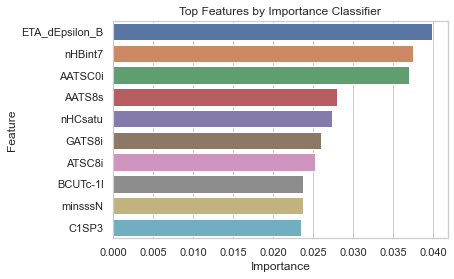

In [7]:
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top Features by Importance Classifier')

plt.savefig('important_features.png', dpi=500, bbox_inches='tight')

In [42]:
###### SHAP

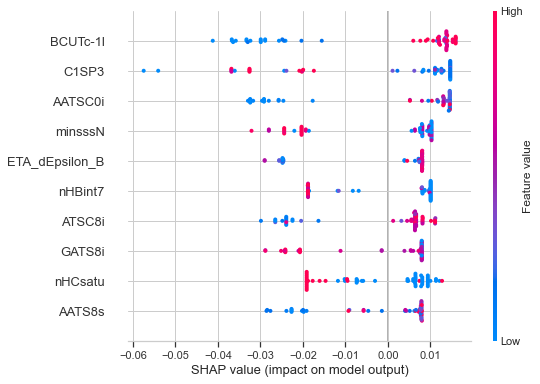

In [8]:
import shap

explainer = shap.TreeExplainer(rf_clf)

shap_values = explainer.shap_values(X)

shap_values_df = pd.DataFrame(shap_values[1], columns=X.columns)

mean_abs_shap = np.abs(shap_values_df).mean(axis=0)
mean_abs_shap_df = pd.DataFrame(mean_abs_shap, columns=['Mean Absolute SHAP Value'])
mean_abs_shap_df['Feature'] = mean_abs_shap_df.index

# Selecting top 10 
top_10_features = mean_abs_shap_df.sort_values(by='Mean Absolute SHAP Value', ascending=False).head(10)

#summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1][:, shap_values_df.columns.isin(top_10_features['Feature'])], 
                  X[top_10_features['Feature']], show=False) 

plt.savefig('shap_summary_plot_class.png', bbox_inches='tight', dpi=300) 

plt.show()


###### We will combine all the features from both analysis and use set to get only the unique ones

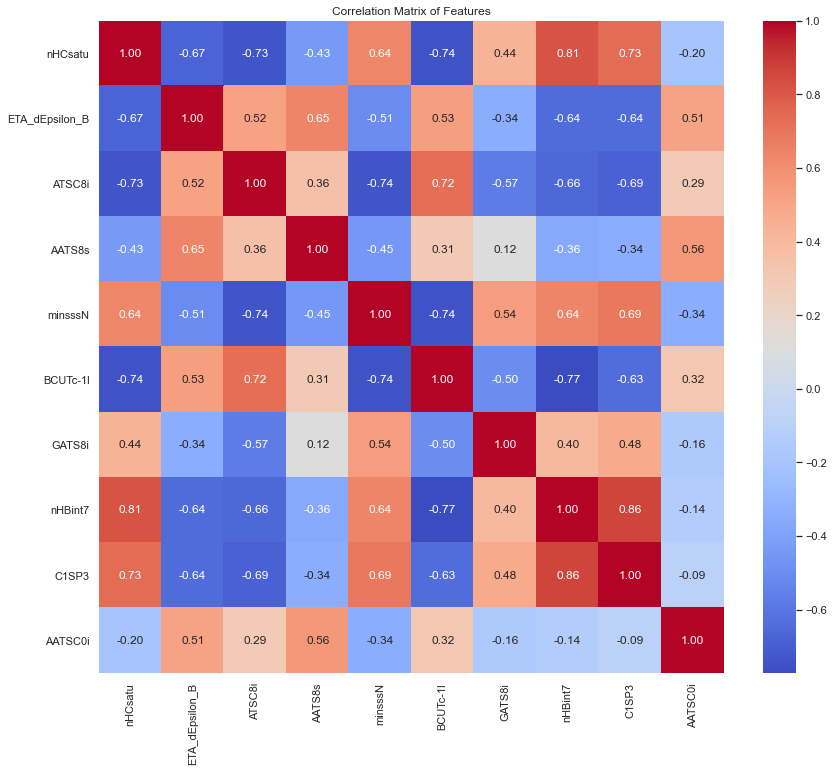

In [9]:
#correlation matrix
features = list(set(top_10_features['Feature'].tolist()+importance_df['Feature'].tolist()))

X =df[features]

correlation_matrix= X.corr()
plt.figure(figsize=(14, 12))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")

plt.savefig('correlation_heatmap_class.png', dpi=300)
plt.show()

From the plot above there are no apparent highly correlated features. we will then calculate the VIF which will sure multicollinearity if it exists. 
- nHCSatu is stronly correlated to nHBint7
- nHBint7 With C1SP3, BCUTC-1L
- - Delete 

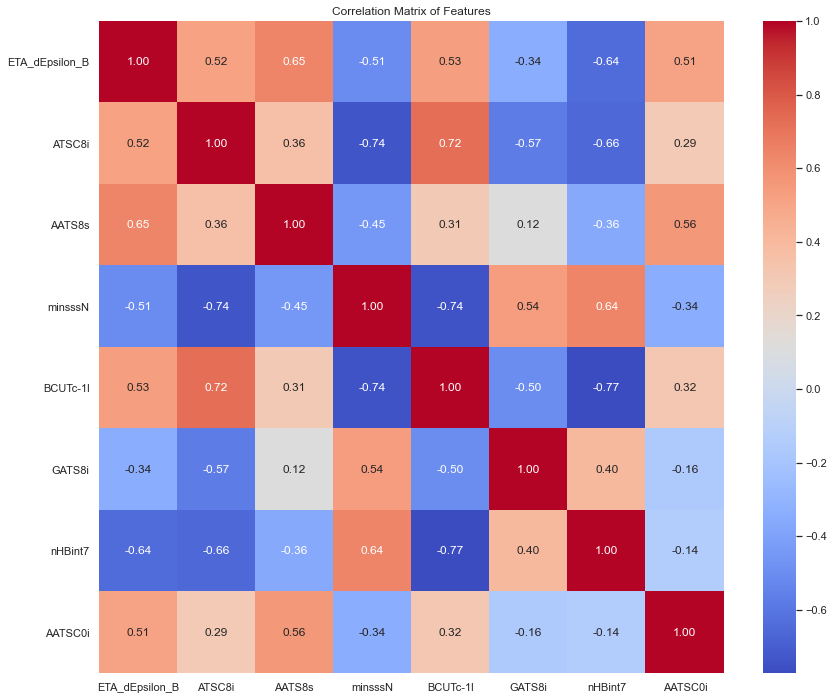

In [10]:
del_features = ['nHCsatu', 'C1SP3']

features = [item for item in features if item not in del_features]

X =df[features]

correlation_matrix= X.corr()
plt.figure(figsize=(14, 12))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
# Save the figure as a PNG file
plt.savefig('correlation_heatmap_class.png', dpi=300)
plt.show()


###### After removing feautues of correlation above 0.75 now I will chek for VIF

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant for intercept
x = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["features"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

# Display the results
print(vif_data)

         features         VIF
0           const  276.022646
1  ETA_dEpsilon_B    3.542618
2          ATSC8i    3.011177
3          AATS8s    3.715431
4         minsssN    3.637764
5        BCUTc-1l    3.980537
6          GATS8i    2.765084
7         nHBint7    4.000325
8         AATSC0i    2.007715


These are  the features of which i will be working with for Machine Learning

#### Class balance visual

when working with classification we need to check the class balance. this is so because if there is class imbalance it will lead to having one class being more favoured than the other.

In [12]:
print(df['bioactivity_class'].value_counts())

1    40
0    20
Name: bioactivity_class, dtype: int64


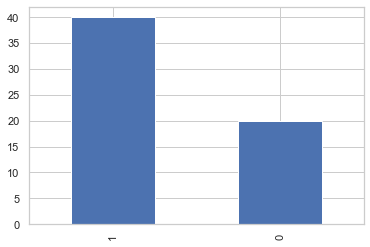

In [13]:
df['bioactivity_class'].value_counts().plot(kind='bar')
plt.show()

from the plot it can be deduced that the dataset has 50% more of active compounds of which will lead to bias towards active. Therefore, to remedy this, the dataset will be oversampled to make the it equal.

There are methods to resample so that the data can be equal which is oversampling and undersampling. the oversampling waschosen becayuse undersampling might remove the important data as I already have a small data set.

- X_train an y_train. Need to specify scaffolds to make sure they fall in the training data and the do the standard train test split.

In [14]:
features = ['ETA_dEpsilon_B', 'GATS8i', 'nHBint7', 'minsssN', 'ATSC8i', 'AATSC0i', 'AATS8s']

#### Understanding Descriptor contribution through visuals

- in this section the contribution of descriptor is evaluated. it helps in visualizing the molecular structures. so it is important that in the index is known. 

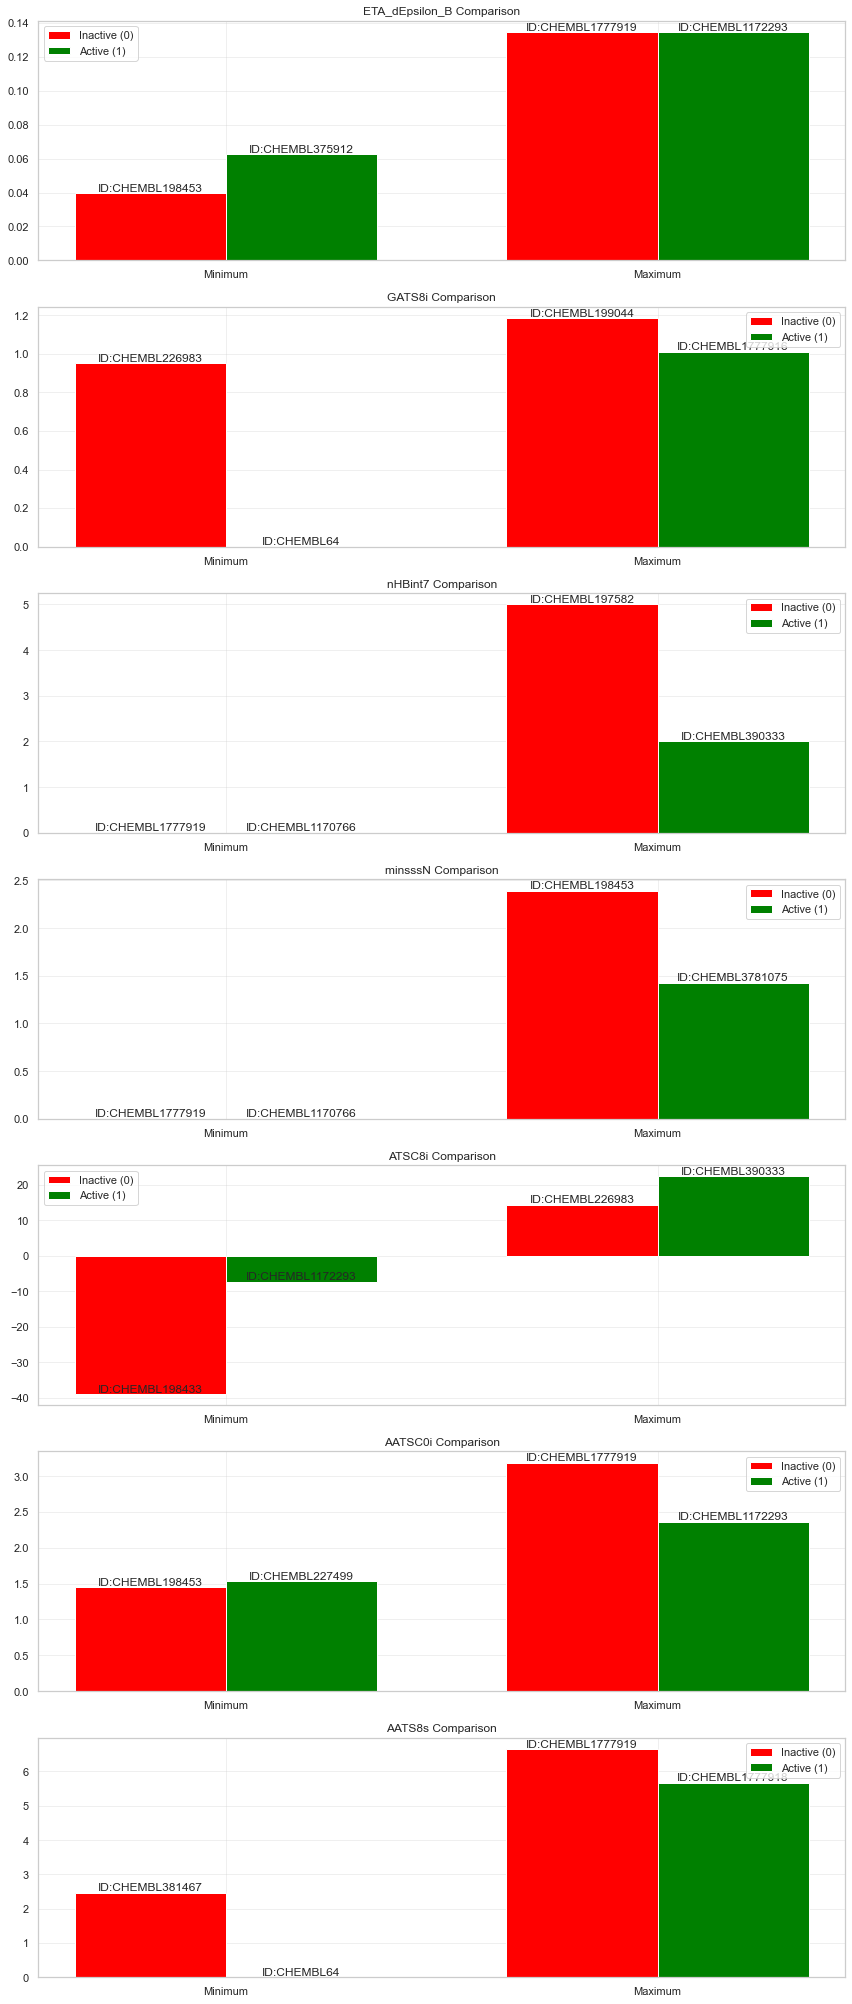

Descriptors statistics:


bioactivity_class              0                                              \
                          AATS8s        AATSC0i        ATSC8i ETA_dEpsilon_B   
max                     6.653752       3.183546     14.408218        0.13459   
max_compound       CHEMBL1777919  CHEMBL1777919  CHEMBL226983  CHEMBL1777919   
min                     2.471614       1.446974    -38.965791         0.0397   
min_compound        CHEMBL381467   CHEMBL198453  CHEMBL198433   CHEMBL198453   

bioactivity_class                                                          1  \
                         GATS8i        minsssN        nHBint7         AATS8s   
max                    1.185316       2.392385            5.0       5.674769   
max_compound       CHEMBL199044   CHEMBL198453   CHEMBL197582  CHEMBL1777918   
min                    0.952618            0.0            0.0            0.0   
min_compound       CHEMBL226983  CHEMBL1777919  CHEMBL1777919       CHEMBL64   

bioactivity_class                                                              \
                         AATSC0i         ATSC8i ETA_dEpsilon_B         GATS8i   
max                     2.364893      22.405075         0.1345       1.012366   
max_compound       CHEMBL1172293   CHEMBL390333  CHEMBL1172293  CHEMBL1777916   
min                     1.533749      -7.326225         0.0626            0.0   
min_compound        CHEMBL227499  CHEMBL1172293   CHEMBL375912       CHEMBL64   

bioactivity_class                                
                         minsssN        nHBint7  
max                     1.425003            2.0  
max_compound       CHEMBL3781075   CHEMBL390333  
min                          0.0            0.0  
min_compound       CHEMBL1170766  CHEMBL1170766

In [15]:
activity_stats = df.groupby('bioactivity_class').agg({
    feature: [
        ('min', lambda x: x.min()),
        ('min_compound', lambda x: x.idxmin()),
        ('max', lambda x: x.max()),
        ('max_compound', lambda x: x.idxmax())
    ] for feature in features
})

n_features = len(features)

#Comparison plot
fig, axs = plt.subplots(n_features, 1, figsize=(12, 4*n_features))

for idx, feature in enumerate(features):
    ax = axs[idx] if n_features > 1 else axs
    class0_min = activity_stats.loc[0][feature]['min']
    class0_min_id = activity_stats.loc[0][feature]['min_compound']
    class0_max = activity_stats.loc[0][feature]['max']
    class0_max_id = activity_stats.loc[0][feature]['max_compound']
    
    class1_min = activity_stats.loc[1][feature]['min']
    class1_min_id = activity_stats.loc[1][feature]['min_compound']
    class1_max = activity_stats.loc[1][feature]['max']
    class1_max_id = activity_stats.loc[1][feature]['max_compound']
    
    #onfiguration
    bar_width = 0.35
    x = np.arange(2)
    
    # Class 0 bars
    ax.bar(x - bar_width/2, [class0_min, class0_max], 
           width=bar_width, label='Inactive (0)', color='red')
    
    # Class 1 bars
    ax.bar(x + bar_width/2, [class1_min, class1_max], 
           width=bar_width, label='Active (1)', color='green')
    
    #compound IDs
    ax.text(x[0] - bar_width/2, class0_min, f'ID:{class0_min_id}', 
            ha='center', va='bottom')
    ax.text(x[1] - bar_width/2, class0_max, f'ID:{class0_max_id}', 
            ha='center', va='bottom')
    ax.text(x[0] + bar_width/2, class1_min, f'ID:{class1_min_id}', 
            ha='center', va='bottom')
    ax.text(x[1] + bar_width/2, class1_max, f'ID:{class1_max_id}', 
            ha='center', va='bottom')
    
    ax.set_title(f'{feature} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(['Minimum', 'Maximum'])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Descriptors statistics:")
display(activity_stats.stack(level=0).T)


In [16]:
activity_stats.stack(level=0).T.to_csv('stats.csv')

## ML
- This part we use the same compunds that we used in regression and do 80-20 split before we can fit our models.

In [35]:
X = df[features]
y = df['bioactivity_class']

# Scaling descriptors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=df.index)

# chosen scaffolds same as that in regression model
chosen_scaffolds = ['CHEMBL1087717', 'CHEMBL226983', 'CHEMBL3780092', 'CHEMBL3780593', 'CHEMBL196076',
                    'CHEMBL197852', 'CHEMBL226069', 'CHEMBL3330937', 'CHEMBL64', 'CHEMBL1171167',
                    'CHEMBL197852', 'CHEMBL227499', 'CHEMBL1172698', 'CHEMBL390333']  

##index of scaffolds
chosen_indices = df.index[df.index.isin(chosen_scaffolds)].tolist()


X_chosen = X_scaled.loc[chosen_indices]
y_chosen = y.loc[chosen_indices]


remaining_indices = [i for i in X_scaled.index if i not in chosen_indices]
X_remaining = X_scaled.loc[remaining_indices]
y_remaining = y.loc[remaining_indices]


X_train_remaining, X_test, y_train_remaining, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=42)


X_train = pd.concat([X_chosen, X_train_remaining], ignore_index=False)
y_train = pd.concat([y_chosen, y_train_remaining], ignore_index=False)

print("Final X_train shape:", X_train.shape)
print("Final y_train shape:", y_train.shape)
print("Final X_test shape:", X_test.shape)
print("Final y_test shape:", y_test.shape)

Final X_train shape: (50, 7)
Final y_train shape: (50,)
Final X_test shape: (10, 7)
Final y_test shape: (10,)


#### Fitting the chosen models

In [25]:
#here the classifiers that willb be used
classifiers = {
    'naive_bayes': {'model': GaussianNB()},
    'knn': {'model': KNeighborsClassifier(n_neighbors=7)},
    'decision_tree': {'model': DecisionTreeClassifier(max_depth=3)},
    'random_forest': {'model': RandomForestClassifier(random_state=1)},
    'gradient_boosting': {'model': GradientBoostingClassifier(random_state=1)},
    'ada_boost': {'model': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)},
    'svm': {'model': SVC(probability=True)}, 
    "logistic_regression": {"model": LogisticRegression(max_iter=200)}}

##### Evaluating the models.
- We want to see which performs the best. 

In [28]:
# list to strore training/testing split    
results = pd.DataFrame(columns=['classifier', 
                                "acc_train", 
                                "acc_test", 
                                "Precision", 
                                "Recall", 
                                "F1_Score"])

def calculate_metrics(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    acc_train = accuracy_score(y_true= y_train, y_pred= y_train_pred)
    acc_test = accuracy_score(y_true= y_test, y_pred=y_test_pred)
    precision_value = precision_score(y_true =y_test, y_pred=y_test_pred, average="weighted")
    recall_value = recall_score(y_true=y_test, y_pred=y_test_pred, average="weighted")
    f_1_value = f1_score(y_true=y_test, y_pred=y_test_pred, average="weighted")
    
    return [acc_train, acc_test, precision_value, recall_value, f_1_value]

loo = LeaveOneOut()

for name, clf in classifiers.items():
    accuracies_train = []
    accuracies_test = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for train_index, test_index in loo.split(X):
        X_train_res, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_res, y_test = y.iloc[train_index], y.iloc[test_index]
        
        metrics = calculate_metrics(clf['model'], X_train, y_train, X_test, y_test)
        
        # Append results to lists
        accuracies_train.append(metrics[0])
        accuracies_test.append(metrics[1])
        precisions.append(metrics[2])
        recalls.append(metrics[3])
        f1_scores.append(metrics[4])
        
        # Append results to DataFrame
        results.loc[len(results)] = [name] + metrics

    # Calculate average metrics across all iterations for each model to three decimal
    average_accuracy_train = round(np.mean(accuracies_train), 3)
    average_accuracy_test = round(np.mean(accuracies_test), 3)
    average_precision = round(np.mean(precisions), 3)
    average_recall = round(np.mean(recalls), 3)
    average_f1_score = round(np.mean(f1_scores), 3)
    
    print(f"Classifier: {name}")
    print(f"Average Train Accuracy: {average_accuracy_train}")
    print(f"Average Test Accuracy: {average_accuracy_test}")
    print(f"Average Precision: {average_precision}")
    print(f"Average Recall: {average_recall}")
    print(f"Average F1 Score: {average_f1_score}")
    print("-" * 20)

results

Classifier: naive_bayes
Average Train Accuracy: 0.94
Average Test Accuracy: 0.45
Average Precision: 0.45
Average Recall: 0.45
Average F1 Score: 0.45
--------------------
Classifier: knn
Average Train Accuracy: 0.9
Average Test Accuracy: 0.867
Average Precision: 0.867
Average Recall: 0.867
Average F1 Score: 0.867
--------------------
Classifier: decision_tree
Average Train Accuracy: 0.98
Average Test Accuracy: 0.567
Average Precision: 0.567
Average Recall: 0.567
Average F1 Score: 0.567
--------------------
Classifier: random_forest
Average Train Accuracy: 1.0
Average Test Accuracy: 0.533
Average Precision: 0.533
Average Recall: 0.533
Average F1 Score: 0.533
--------------------
Classifier: gradient_boosting
Average Train Accuracy: 1.0
Average Test Accuracy: 0.533
Average Precision: 0.533
Average Recall: 0.533
Average F1 Score: 0.533
--------------------
Classifier: ada_boost
Average Train Accuracy: 1.0
Average Test Accuracy: 0.467
Average Precision: 0.467
Average Recall: 0.467
Average F

,classifier,acc_train,acc_test,Precision,Recall,F1_Score
0,naive_bayes,0.94,0.0,0.0,0.0,0.0
1,naive_bayes,0.94,1.0,1.0,1.0,1.0
2,naive_bayes,0.94,0.0,0.0,0.0,0.0
3,naive_bayes,0.94,0.0,0.0,0.0,0.0
4,naive_bayes,0.94,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
475,logistic_regression,0.94,0.0,0.0,0.0,0.0
476,logistic_regression,0.94,0.0,0.0,0.0,0.0
477,logistic_regression,0.94,1.0,1.0,1.0,1.0
478,logistic_regression,0.94,0.0,0.0,0.0,0.0


In [20]:
results.to_csv('results_class')

- From the results above, it can be noted that Knn is the best performing model. in terms of how the data fits the train and test. the accuracy is goog as compared to other models.
- however, we are cognisant that the data is imbalanced. 
- lets what other parameters tell about our model.

In [20]:
# Define classifiers
classifiers = {
    'naive_bayes': GaussianNB(),
    'knn': KNeighborsClassifier(n_neighbors=7),
    'decision_tree': DecisionTreeClassifier(max_depth=3),
    'random_forest': RandomForestClassifier(random_state=1),
    'gradient_boosting': GradientBoostingClassifier(random_state=1),
    'ada_boost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50),
    'svm': SVC(probability=True), 
    "logistic_regression": LogisticRegression(max_iter=200)
}

loo = LeaveOneOut()

for name, clf in classifiers.items():
    y_true = []
    y_pred = []
    
    #LOO CV
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        
        y_true.append(y_test.values[0])  
        y_pred.append(pred[0])  
    
    # MCC calculation
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC (LOO) for {name}: {mcc:.4f}")


MCC (LOO) for naive_bayes: 0.8487
MCC (LOO) for knn: 0.8165
MCC (LOO) for decision_tree: 0.8528
MCC (LOO) for random_forest: 0.8892
MCC (LOO) for gradient_boosting: 0.8528
MCC (LOO) for ada_boost: 0.8108
MCC (LOO) for svm: 0.8165
MCC (LOO) for logistic_regression: 0.8108


- The MCC which is an important measure for imbalanced data is good for all models.
- from here we cant say knn is still the best as RF shows better MCC

In [21]:
# Instantiate and fit each model
nb = GaussianNB()
nb.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train, y_train)

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
ada.fit(X_train, y_train)

svm = SVC(probability=True)
svm.fit(X_train, y_train)

lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200)

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

The ROC curve is plotted with TPR against the FPR

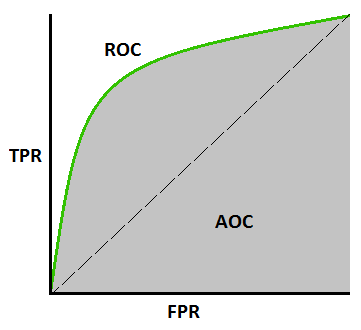


- In this part we will use AUC-ROC to see wich model is the best. 
- The ROC uses probability and AUC shows how the model separates. 
- in short this parameter will tell us if the model is capable of separting classes or differentiating the two classes.

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score


#Predict probabilities for each model
rf_probs = rf.predict_proba(X_test)[:, 1]
nb_probs = nb.predict_proba(X_test)[:, 1]
knn_probs = knn.predict_proba(X_test)[:, 1]
dt_probs = dt.predict_proba(X_test)[:, 1]
gb_probs = gb.predict_proba(X_test)[:, 1]
ada_probs = ada.predict_proba(X_test)[:, 1]
svm_probs = svm.predict_proba(X_test)[:, 1]
lr_probs = lr.predict_proba(X_test)[:, 1]


# Calculate AUC-ROC for each model
rf_auc = roc_auc_score(y_test, rf_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
gb_auc = roc_auc_score(y_test, gb_probs)
ada_auc = roc_auc_score(y_test, ada_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# Print AUC-ROC for each model
print("AUC-ROC Values:")
print(f"Random Forest: {rf_auc:.4f}")
print(f"Naive Bayes: {nb_auc:.4f}")
print(f"KNN: {knn_auc:.4f}")
print(f"Decision Tree: {dt_auc:.4f}")
print(f"Gradient Boosting: {gb_auc:.4f}")
print(f"AdaBoost: {ada_auc:.4f}")
print(f"SVM: {svm_auc:.4f}")
print(f"Logistic Regression: {lr_auc:.4f}")
#Calculate ROC curves for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

AUC-ROC Values:
Random Forest: 1.0000
Naive Bayes: 1.0000
KNN: 0.5000
Decision Tree: 0.5000
Gradient Boosting: 0.9375
AdaBoost: 0.5000
SVM: 1.0000
Logistic Regression: 1.0000


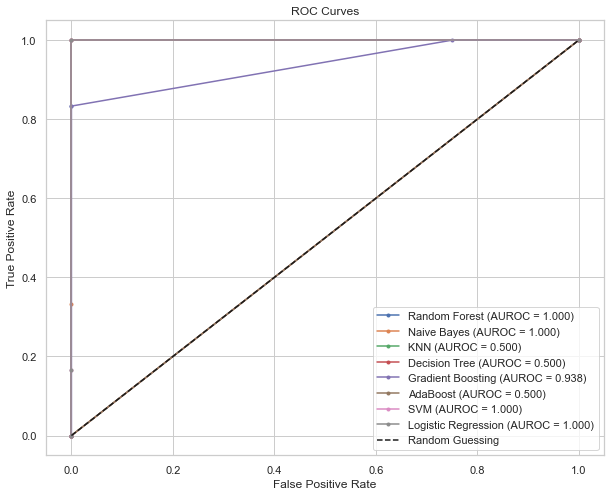

In [27]:
# Plot ROC curves for each model
plt.figure(figsize=(10, 8))

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (AUROC = %0.3f)' % knn_auc)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % dt_auc)
plt.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boosting (AUROC = %0.3f)' % gb_auc)
plt.plot(ada_fpr, ada_tpr, marker='.', label='AdaBoost (AUROC = %0.3f)' % ada_auc)
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM (AUROC = %0.3f)' % svm_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)

# Add a random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

plt.savefig('roc_curves.png', bbox_inches='tight')

plt.show()

- The plot above shows that RF, Naive bayes and SVM can separate classes very well. while others have lower values. 
- earlier we had said that KNN is the best model, but now we see that it is not capable of distiguishing between classes.

#### We will now resample so that the two classes are equal
- we will use the SMOTE approach


In [30]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library

from imblearn.over_sampling import SMOTE  # Example
sm = SMOTE(random_state=1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 34
Before OverSampling, counts of label '0': 16 

After OverSampling, the shape of train_X: (68, 7)
After OverSampling, the shape of train_y: (68,) 

After OverSampling, counts of label '1': 34
After OverSampling, counts of label '0': 34


- oversampling we will start the process of evaluating on the resampled data.

In [31]:
loo = LeaveOneOut()

for name, clf in classifiers.items():
    accuracies_train = []
    accuracies_test = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in loo.split(X):
        X_train_res, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_res, y_test = y.iloc[train_index], y.iloc[test_index]

        metrics = calculate_metrics(clf['model'], X_train_res, y_train_res, X_test, y_test)

        # Append results to lists
        accuracies_train.append(metrics[0])
        accuracies_test.append(metrics[1])
        precisions.append(metrics[2])
        recalls.append(metrics[3])
        f1_scores.append(metrics[4])

        # Append results to DataFrame
        results.loc[len(results)] = [name] + metrics

    # Calculate average metrics across all iterations for each model to three decimal
    average_accuracy_train = round(np.mean(accuracies_train), 3)
    average_accuracy_test = round(np.mean(accuracies_test), 3)
    average_precision = round(np.mean(precisions), 3)
    average_recall = round(np.mean(recalls), 3)
    average_f1_score = round(np.mean(f1_scores), 3)

    print(f"Classifier: {name}")
    print(f"Average Train Accuracy: {average_accuracy_train}")
    print(f"Average Test Accuracy: {average_accuracy_test}")
    print(f"Average Precision: {average_precision}")
    print(f"Average Recall: {average_recall}")
    print(f"Average F1 Score: {average_f1_score}")
    print("-" * 20)

results

Classifier: naive_bayes
Average Train Accuracy: 0.95
Average Test Accuracy: 0.933
Average Precision: 0.933
Average Recall: 0.933
Average F1 Score: 0.933
--------------------
Classifier: knn
Average Train Accuracy: 0.918
Average Test Accuracy: 0.917
Average Precision: 0.917
Average Recall: 0.917
Average F1 Score: 0.917
--------------------
Classifier: decision_tree
Average Train Accuracy: 0.984
Average Test Accuracy: 0.917
Average Precision: 0.917
Average Recall: 0.917
Average F1 Score: 0.917
--------------------
Classifier: random_forest
Average Train Accuracy: 1.0
Average Test Accuracy: 0.95
Average Precision: 0.95
Average Recall: 0.95
Average F1 Score: 0.95
--------------------
Classifier: gradient_boosting
Average Train Accuracy: 1.0
Average Test Accuracy: 0.933
Average Precision: 0.933
Average Recall: 0.933
Average F1 Score: 0.933
--------------------
Classifier: ada_boost
Average Train Accuracy: 1.0
Average Test Accuracy: 0.933
Average Precision: 0.933
Average Recall: 0.933
Averag

,classifier,acc_train,acc_test,Precision,Recall,F1_Score
0,naive_bayes,0.940000,0.0,0.0,0.0,0.0
1,naive_bayes,0.940000,1.0,1.0,1.0,1.0
2,naive_bayes,0.940000,0.0,0.0,0.0,0.0
3,naive_bayes,0.940000,0.0,0.0,0.0,0.0
4,naive_bayes,0.940000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
955,logistic_regression,0.949153,1.0,1.0,1.0,1.0
956,logistic_regression,0.949153,1.0,1.0,1.0,1.0
957,logistic_regression,0.949153,1.0,1.0,1.0,1.0
958,logistic_regression,0.949153,1.0,1.0,1.0,1.0


- The results are much better than those of classes that were imbalanced.

In [32]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import matthews_corrcoef
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Define classifiers
classifiers = {
    'naive_bayes': GaussianNB(),
    'knn': KNeighborsClassifier(n_neighbors=7),
    'decision_tree': DecisionTreeClassifier(max_depth=3),
    'random_forest': RandomForestClassifier(random_state=1),
    'gradient_boosting': GradientBoostingClassifier(random_state=1),
    'ada_boost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50),
    'svm': SVC(probability=True),
    "logistic_regression": LogisticRegression(max_iter=200)
}

# Perform LOO for each classifier
loo = LeaveOneOut()

for name, clf in classifiers.items():
    y_true = []
    y_pred = []

    # Perform LOO cross-validation
    for train_index, test_index in loo.split(X):
        X_train_res, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_res, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train_res, y_train_res)
        pred = clf.predict(X_test)

        y_true.append(y_test.values[0])  # Convert to scalar
        y_pred.append(pred[0])  # Convert to scalar

    # Calculate MCC once after collecting all predictions
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC (LOO) for {name}: {mcc:.4f}")


MCC (LOO) for naive_bayes: 0.8487
MCC (LOO) for knn: 0.8165
MCC (LOO) for decision_tree: 0.8108
MCC (LOO) for random_forest: 0.8892
MCC (LOO) for gradient_boosting: 0.8528
MCC (LOO) for ada_boost: 0.8528
MCC (LOO) for svm: 0.8165
MCC (LOO) for logistic_regression: 0.8108


In [33]:
# Instantiate and fit each model
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_res, y_train_res)

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_res, y_train_res)

rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_res, y_train_res)

gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train_res, y_train_res)

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
ada.fit(X_train_res, y_train_res)

svm = SVC(probability=True)
svm.fit(X_train_res, y_train_res)

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=200)

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score


# Predict probabilities for each model
rf_probs = rf.predict_proba(X_test)[:, 1]
nb_probs = nb.predict_proba(X_test)[:, 1]
knn_probs = knn.predict_proba(X_test)[:, 1]
dt_probs = dt.predict_proba(X_test)[:, 1]
gb_probs = gb.predict_proba(X_test)[:, 1]
ada_probs = ada.predict_proba(X_test)[:, 1]
svm_probs = svm.predict_proba(X_test)[:, 1]
lr_probs = lr.predict_proba(X_test)[:, 1]


# Calculate AUC-ROC for each model
rf_auc = roc_auc_score(y_test, rf_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
gb_auc = roc_auc_score(y_test, gb_probs)
ada_auc = roc_auc_score(y_test, ada_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# Print AUC-ROC for each model
print("AUC-ROC Values:")
print(f"Random Forest: {rf_auc:.4f}")
print(f"Naive Bayes: {nb_auc:.4f}")
print(f"KNN: {knn_auc:.4f}")
print(f"Decision Tree: {dt_auc:.4f}")
print(f"Gradient Boosting: {gb_auc:.4f}")
print(f"AdaBoost: {ada_auc:.4f}")
print(f"SVM: {svm_auc:.4f}")
print(f"Logistic Regression: {lr_auc:.4f}")
# Calculate ROC curves for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

AUC-ROC Values:
Random Forest: 1.0000
Naive Bayes: 1.0000
KNN: 0.5000
Decision Tree: 0.9167
Gradient Boosting: 0.9375
AdaBoost: 0.5000
SVM: 1.0000
Logistic Regression: 1.0000


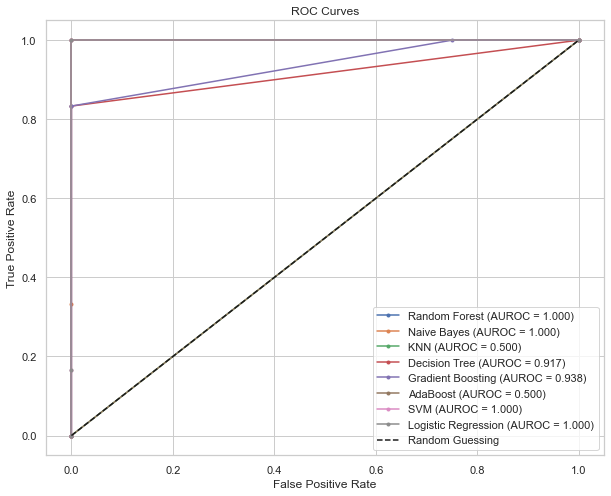

In [37]:
# Plot ROC curves for each model
plt.figure(figsize=(10, 8))

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (AUROC = %0.3f)' % knn_auc)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % dt_auc)
plt.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boosting (AUROC = %0.3f)' % gb_auc)
plt.plot(ada_fpr, ada_tpr, marker='.', label='AdaBoost (AUROC = %0.3f)' % ada_auc)
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM (AUROC = %0.3f)' % svm_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)

# Add a random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

plt.savefig('roc_curves.png', bbox_inches='tight')

plt.show()

From this it can be deduced that Naive Bayes is the best as it has the good accuracy for train, and test data. the MCC score of Naive is good, though not > than that of RF, the naive has the best balanced. also, it can distiguish between classes accurately. 

###### Now that we have satistified ourselves with the best model that we will use. we will then do application domain

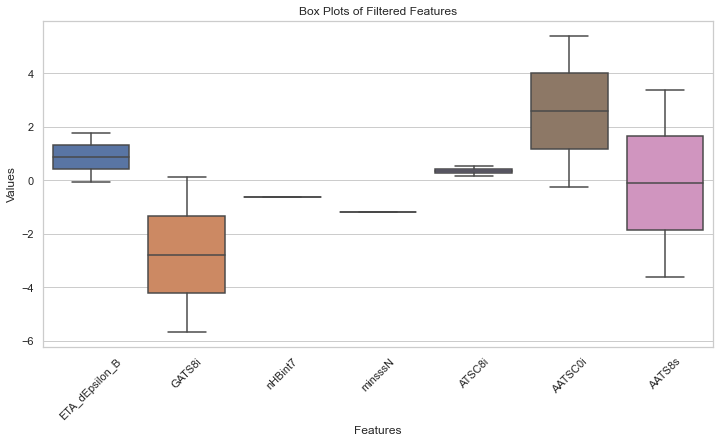

In [38]:
from scipy import stats, optimize, interpolate

# Calculate Z-scores for X_train and identify outliers
z_scores = np.abs(stats.zscore(X_train))
outlier_threshold = 3

# Identify outliers based on Z-score threshold
outliers_count = (z_scores > outlier_threshold).sum(axis=1)

# Create a Series for outlier counts based on X_train index
outlier_counts_series = pd.Series(outliers_count, index=X_train.index)

# Initialize outlier_count column in df with zeros or NaNs
X_train['outlier_count'] = np.zeros(len(X_train))

# Assign outlier counts back to df using the same index for only those in X_train
X_train.loc[outlier_counts_series.index, 'outlier_count'] = outlier_counts_series

# Filter compounds with outlier count greater than 1
filtered_df = X_train[X_train['outlier_count'] > 0]

numeric_columns = filtered_df.drop(columns=['outlier_count'], errors='ignore').columns

#box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df[numeric_columns])
plt.title('Box Plots of Filtered Features')
plt.ylabel('Values')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.savefig('outliers.png', bbox_inches='tight')

plt.show()


In [39]:
filtered_df.head()

,ETA_dEpsilon_B,GATS8i,nHBint7,minsssN,ATSC8i,AATSC0i,AATS8s,outlier_count
molecule_chembl_id,,,,,,,,
CHEMBL64,-0.042607,-5.676182,-0.6295,-1.171533,0.176735,-0.229457,-3.61121,2
CHEMBL1777919,1.784074,0.130031,-0.6295,-1.171533,0.532296,5.411821,3.39800,2


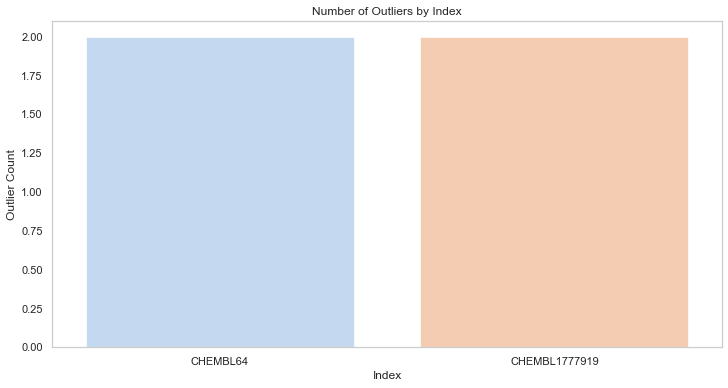

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=filtered_df, x=filtered_df.index, y='outlier_count', palette='pastel', alpha=0.7)

# Add labels and title
plt.title('Number of Outliers by Index')
plt.xlabel('Index')
plt.ylabel('Outlier Count')

# Show grid for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('outliers.png', bbox_inches='tight')


# Show the plot
plt.show()


For our AD, we look at the compounds that have many outliers. and this compounds cannot be used to determine new compounds. the molecule CHEMBL64 is INH compound of which is expected as it highest activity. therefore, in reality only compound CHEMBL1777919 should not be used as template in the design of new derivatives.

##### Credits
Generative AI was used to generate some of the codes.